In [162]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Peak in sensitivity persists in renewed data - can we get rid of it with alternative starting states?

# Imports

In [163]:
import os
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.misc.units import per_mol_to_per_molecule
from synbio_morpher.utils.common.setup import prepare_config, construct_circuit_from_cfg
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.misc.type_handling import flatten_listlike

# jupyter nbconvert --to notebook --execute 25_sensitivity_peak_2.ipynb --output=25_sensitivity_peak_2_1.ipynb --ExecutePreprocessor.timeout=-1



# Analysis of generated data

1. What is the value of the sensitivity peak ($s_{peak}$)?
2. Which circuits get an $s_{peak}$?
3. What does the peak depend on? Could it be...
    - Forward rate
    - Initial state
    - Value of signal input
4. Is there a better way of simulating circuits where some components have no interaction? Can we assign a zero rate in both directions??

## Load data

In [164]:
fn = '../data/ensemble_mutation_effect_analysis/2024_11_11_135219/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,sample_num,name,interacting,...,initial_steady_states,max_amount,min_amount,overshoot,RMSE,steady_states,response_time_wrt_species-6,precision_wrt_species-6,sensitivity_wrt_species-6,sample_name
0,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,400.0,199.73235,0.802002,0.000000,399.19800,0.0,1.004021,1.000000,RNA_0
1,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
2,toy_mRNA_circuit_0,ref_circuit,0,[],[],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_2
3,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,400.0,199.73235,0.802002,0.000000,399.19800,0.0,1.004021,1.000000,RNA_0
4,toy_mRNA_circuit_0,RNA_0_m1-0,1,[3],[18],./data/ensemble_mutation_effect_analysis/2024_...,0.0,9.0,toy_mRNA_circuit_0,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,toy_mRNA_circuit_99,RNA_2_m1-0,1,[8],[9],./data/ensemble_mutation_effect_analysis/2024_...,4.0,9.0,toy_mRNA_circuit_99,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_1
6296,toy_mRNA_circuit_99,RNA_2_m1-0,1,[8],[9],./data/ensemble_mutation_effect_analysis/2024_...,4.0,9.0,toy_mRNA_circuit_99,[],...,199.73235,200.0,199.66568,0.000000,0.000000,199.66568,0.0,3004.060800,0.000333,RNA_2
6297,toy_mRNA_circuit_99,RNA_2_m1-1,1,[2],[14],./data/ensemble_mutation_effect_analysis/2024_...,5.0,9.0,toy_mRNA_circuit_99,[[1 2]],...,199.74307,400.0,199.74307,0.780518,0.021447,399.21948,0.0,1.003913,1.000000,RNA_0
6298,toy_mRNA_circuit_99,RNA_2_m1-1,1,[2],[14],./data/ensemble_mutation_effect_analysis/2024_...,5.0,9.0,toy_mRNA_circuit_99,[[1 2]],...,192.17154,200.0,192.11177,0.000000,7.546352,192.11177,0.0,3223.526400,0.000310,RNA_1


## Value of sensitivity peak

The sensitivity peak is at 0.00033288274


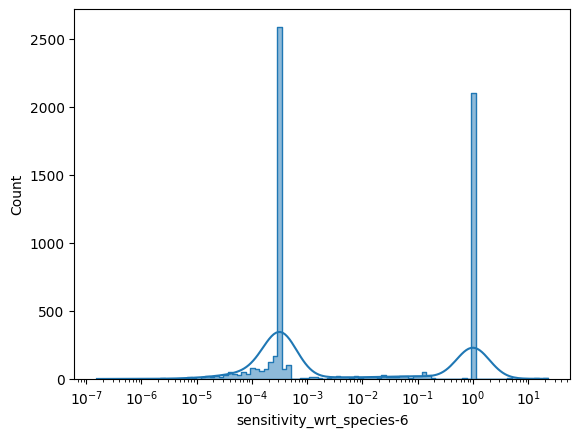

In [165]:
sns.histplot(data, x='sensitivity_wrt_species-6', bins=100, element='step', log_scale=[True, False], kde=True)
s_peak = data['sensitivity_wrt_species-6'].median()
print(f'The sensitivity peak is at {s_peak}')

## Circuits that have the $s_{peak}$

Once again, the circuits at the sensitivity peak are the ones where none of the RNAs are interacting, aka 'null circuits'.

In [166]:
cols_e = get_true_interaction_cols(data, 'energies')
data[data['sensitivity_wrt_species-6'] == s_peak][['circuit_name'] + cols_e].iloc[:5]

,circuit_name,energies_0-0,energies_0-1,energies_0-2,energies_1-0,energies_1-1,energies_1-2,energies_2-0,energies_2-1,energies_2-2
1,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,toy_mRNA_circuit_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
cols_brd = get_true_interaction_cols(data, 'binding_rates_dissociation')
data[data['sensitivity_wrt_species-6'] == s_peak][['circuit_name'] + cols_brd].iloc[:5]

,circuit_name,binding_rates_dissociation_0-0,binding_rates_dissociation_0-1,binding_rates_dissociation_0-2,binding_rates_dissociation_1-0,binding_rates_dissociation_1-1,binding_rates_dissociation_1-2,binding_rates_dissociation_2-0,binding_rates_dissociation_2-1,binding_rates_dissociation_2-2
1,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
2,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
4,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
5,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995
7,toy_mRNA_circuit_0,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995,899.9995


# What does the peak depend on?

Let's construct a bunch of null circuits that have different starting states, forward rates, and signal targets.
Forward rates are usually 1e6 per mol, so we can try different rates like 1e3 to 1e10. These have to be converted to per molecule.

In [168]:
config = load_json_as_dict('../synbio_morpher/utils/common/testing/configs/simple_circuit.json')

n_species = 3

k_a_og = 0.00150958097
forward_rates = np.array(jax.tree_util.tree_map(per_mol_to_per_molecule, jnp.power(10, np.arange(3, 10, 0.5))), dtype=np.float64)
starting_states_all = np.arange(10, 310, 20)
starting_states_all = np.concatenate([starting_states_all[:, None] * np.ones((len(starting_states_all), n_species)), np.random.randint(10, 300, (len(starting_states_all), n_species))])
signal_targets = np.concatenate([np.arange(0.1, 2, 0.1, dtype=np.float64), np.arange(2, 4, 0.5, dtype=np.float64), np.arange(4, 8, 1, dtype=np.float64)], dtype=np.float64)

# n_small = 3
# starting_states_all = starting_states_all[:n_small]
# forward_rates = forward_rates[:n_small]
# signal_targets = signal_targets[:n_small]

print(f'There are a total of {len(starting_states_all) * len(forward_rates) * len(signal_targets)} simulations to run')


There are a total of 11340 simulations to run


In [169]:
config = prepare_config(config)
config['include_prod_deg'] = False
config['simulation']['batch_size'] = 1000
config['simulation']['device'] = 'gpu'
config['simulation']['dt0'] = 0.005
config['simulation']['dt1'] = 0.005 / 2
config['simulation']['t0'] = 0
config['simulation']['t1'] = 10
config['simulation']['tmax'] = 1500
config['simulation']['use_initial_to_add_signal'] = False
config['simulation']['use_rate_scaling'] = True
config['signal']['function_kwargs']['target'] = 2


In [170]:
def load_circuit(k_a, energies, eqconstants, starting_states, signal_target):
    c = {'data_path': data[data['sensitivity_wrt_species-6'] == s_peak]['path_to_template_circuit'].iloc[0].replace('./', '../'),
         'molecular_params': config['molecular_params'],
         'signal': config['signal']}
    c['signal']['function_kwargs']['target'] = signal_target
    c['molecular_params']['starting_copynumbers'] = np.mean(starting_states)

    circuit = construct_circuit_from_cfg(c, config)
    circuit.interactions.energies = energies
    circuit.interactions.eqconstants = eqconstants
    circuit.interactions.binding_rates_association = k_a * \
        np.ones_like(eqconstants)
    circuit.interactions.binding_rates_dissociation = k_a / eqconstants
    circuit.interactions_state = 'loaded'
    if type(starting_states) == np.ndarray:
        for i, (s, r) in enumerate(zip(starting_states, circuit.qreactions.reactants)):
            circuit.qreactions.reactants[i].quantity = s
    return circuit


energies = data[data['sensitivity_wrt_species-6']
                == s_peak][cols_e].iloc[0].values.reshape((n_species, n_species))
eqconstants = data[data['sensitivity_wrt_species-6'] ==
                   s_peak][get_true_interaction_cols(data, 'eqconstants')].iloc[0].values.reshape((n_species, n_species))

circuits = []
data_circuits = pd.DataFrame(
    columns=['circuit_name', 'k_a', 'starting_state', 'signal_target', 'circuit'])
for i, (k_a, starting_state, signal_target) in enumerate(itertools.product(forward_rates, starting_states_all, signal_targets)):
    circuit = load_circuit(k_a, energies, eqconstants,
                           starting_state, signal_target)
    name = f'RNA_circuit_{i}'
    circuit.name = name
    data_circuits.loc[i] = [name, k_a, starting_state, signal_target, circuit]
    circuits.append(circuit)

# Run simulation

In [171]:
run_sim = False

In [172]:
if run_sim:
    config, result_writer = script_preamble(
        config=config, data_writer=None)
    config['simulation']['use_rate_scaling'] = True
    circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)

In [173]:
if run_sim:
    new_circuits = []
    bs = config['simulation']['batch_size']
    for i in range(0, len(circuits), bs):
        print(f'step {i}')
        try:
            new_circuits.append(
                circuit_modeller.batch_circuits(
                    circuits=circuits[i:i + bs],
                    batch_size=bs,
                    methods={
                        "compute_interactions": {},
                        "init_circuits": {'batch': True},
                        'simulate_signal_batch': {'ref_circuit': None,
                                                'batch': config['simulation']['use_batch_mutations']},
                        'write_results': {'no_visualisations': False,  # config['experiment']['no_visualisations'],
                                        'no_numerical': False}  # config['experiment']['no_numerical']}
                    }
                )
            )
        except Exception as e:
            print(e)
            print(f'Could not run batch {i} to {i + bs}...')
            print(
                f'Something wrong in {data_circuits.iloc[i:i + bs][["k_a", "starting_state", "signal_target"]]}')
            break
    new_circuits = flatten_listlike(new_circuits)

## Load data

In [174]:
def load_data_circuits(dirname, idxs_output):
    
    df = pd.DataFrame(columns=['circuit_name', 'sensitivity', 'precision', 'overshoot', 'sim failure'])
    for i, dir_circuit in enumerate(os.listdir(dirname)):
        if os.path.exists(os.path.join(dirname, dir_circuit, 'report_signal.json')):
            signal = load_json_as_dict(os.path.join(dirname, dir_circuit, 'report_signal.json'))
            df.loc[i] = [dir_circuit, signal['sensitivity_wrt_species-6'][idxs_output], signal['precision_wrt_species-6'][idxs_output], signal['overshoot'][idxs_output], False]
        else:
            df.loc[i] = [dir_circuit, np.nan, np.nan, np.nan, True]
    df[['sensitivity', 'precision', 'overshoot']] = df[['sensitivity', 'precision', 'overshoot']].astype(float)
    df['adaptability'] = calculate_adaptation(df['sensitivity'].to_numpy(), df['precision'].to_numpy())
    return df

In [175]:
idxs_output = -1

dir_with_rate_scaling = '../data/tests/2024_11_14_214921'
dir_without_rate_scaling = '../data/tests/2024_11_20_153027'

if run_sim:
    for a in new_circuits[0].result_collector.results['signal'].analytics.keys():
        data_circuits[a] = data_circuits['circuit'].apply(lambda c: c.result_collector.results['signal'].analytics[a][idxs_output] if c.result_collector.results.get('signal') else np.nan)
    result_writer.output('data_circuits', 'csv', data=data_circuits.drop(columns=['circuit']))
else:
    # data_circuits load('../data/tests/2024_11_14_214921/summarise_simulation/data_circuits.csv')
    df = load_data_circuits(dir_without_rate_scaling, idxs_output)
    data_circuits.set_index('circuit_name', inplace=True)
    data_circuits = data_circuits[['k_a', 'starting_state', 'signal_target', 'circuit']].join(df.set_index('circuit_name'))
    data_circuits.reset_index(inplace=True)

In [176]:
params_keys = ['k_a', 'signal_target'] 
analytics_keys = ['sensitivity', 'precision', 'adaptability', 'overshoot']

n_species = 3
for i in range(n_species):
    data_circuits[f'starting_state_{i}'] = data_circuits['starting_state'].apply(lambda x: x[i])
    params_keys.append(f'starting_state_{i}')

groupings_analytics = data_circuits[analytics_keys].value_counts().index.to_list()

The number of rows of the following dataframe is the number of unique combinations of sensitivity and precision coming out of the param_keys.

In [177]:
data_circuits.groupby(by=analytics_keys)[params_keys].agg(
    lambda x: list(np.unique(np.round(np.log10(x), 2))) if x.name == 'k_a' else (
        list(np.round(x, 3)) if x.name == 'signal_target' else (
            'n: ' + str(len(np.unique(x))).ljust(3), np.min(x), np.max(x)))) 

k_a  \
sensitivity precision   adaptability overshoot            
0.000005    196603.8600 541.734619   0.000000   [-3.82]   
            193154.7200 542.267395   0.000000   [-4.32]   
            188740.1100 542.962769   0.000000   [-5.32]   
0.000007    195079.9200 551.501587   0.000014   [-4.82]   
0.000016    63332.7770  574.883545   0.000000   [-3.82]   
...                                                 ...   
0.000453    2225.9414   661.772095   0.000824   [-5.32]   
0.000483    2071.4563   663.219849   0.000000   [-4.82]   
            2071.9414   663.221741   0.000031   [-4.82]   
            2070.8147   663.234375   0.000031   [-5.32]   
0.000484    2072.3386   663.307617   0.000458   [-5.82]   

                                                                                    signal_target  \
sensitivity precision   adaptability overshoot                                                      
0.000005    196603.8600 541.734619   0.000000   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   
            193154.7200 542.267395   0.000000   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   
            188740.1100 542.962769   0.000000   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   
0.000007    195079.9200 551.501587   0.000014   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   
0.000016    63332.7770  574.883545   0.000000   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   
...                                                                                           ...   
0.000453    2225.9414   661.772095   0.000824   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   
0.000483    2071.4563   663.219849   0.000000   [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, ...   
            2071.9414   663.221741   0.000031                                               [0.2]   
            2070.8147   663.234375   0.000031   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   
0.000484    2072.3386   663.307617   0.000458   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...   

                                                      starting_state_0  \
sensitivity precision   adaptability overshoot                           
0.000005    196603.8600 541.734619   0.000000     (n: 1  , 10.0, 10.0)   
            193154.7200 542.267395   0.000000     (n: 1  , 10.0, 10.0)   
            188740.1100 542.962769   0.000000     (n: 1  , 10.0, 10.0)   
0.000007    195079.9200 551.501587   0.000014     (n: 1  , 10.0, 10.0)   
0.000016    63332.7770  574.883545   0.000000     (n: 1  , 30.0, 30.0)   
...                                                                ...   
0.000453    2225.9414   661.772095   0.000824   (n: 1  , 270.0, 270.0)   
0.000483    2071.4563   663.219849   0.000000   (n: 1  , 290.0, 290.0)   
            2071.9414   663.221741   0.000031   (n: 1  , 290.0, 290.0)   
            2070.8147   663.234375   0.000031   (n: 1  , 290.0, 290.0)   
0.000484    2072.3386   663.307617   0.000458   (n: 1  , 290.0, 290.0)   

                                                      starting_state_1  \
sensitivity precision   adaptability overshoot                           
0.000005    196603.8600 541.734619   0.000000     (n: 1  , 10.0, 10.0)   
            193154.7200 542.267395   0.000000     (n: 1  , 10.0, 10.0)   
            188740.1100 542.962769   0.000000     (n: 1  , 10.0, 10.0)   
0.000007    195079.9200 551.501587   0.000014     (n: 1  , 10.0, 10.0)   
0.000016    63332.7770  574.883545   0.000000     (n: 1  , 30.0, 30.0)   
...                                                                ...   
0.000453    2225.9414   661.772095   0.000824   (n: 1  , 270.0, 270.0)   
0.000483    2071.4563   663.219849   0.000000   (n: 1  , 290.0, 290.0)   
            2071.9414   663.221741   0.000031   (n: 1  , 290.0, 290.0)   
            2070.8147   663.234375   0.000031   (n: 1  , 290.0, 290.0)   
0.000484    2072.3386   663.307617   0.000458   (n: 1  , 290.0, 290.0)   

                                            

From the histograms, we can also see that the sensitivity peak has indeed been disrupted.

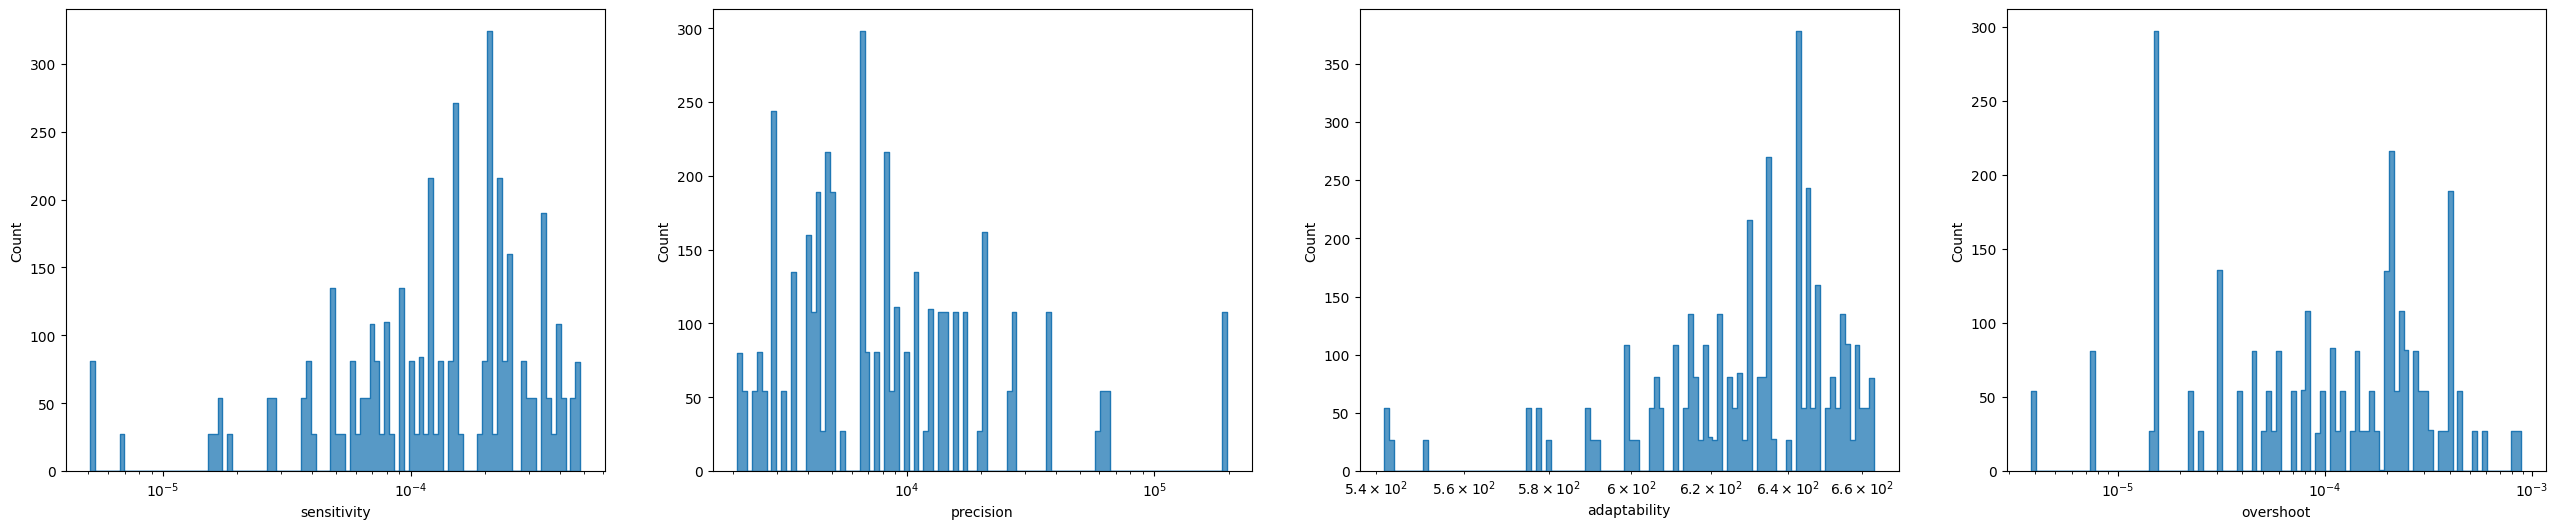

In [178]:
fig = plt.figure(figsize=(len(analytics_keys)*8, 1*6))
# for s in params_keys:
for a in analytics_keys:
    ax = plt.subplot(1, 4, analytics_keys.index(a)+1)
    sns.histplot(data_circuits, x=a, bins=100, log_scale=[True, False], element='step', ax=ax)

In [179]:
def round_to_significant_digits(arr, sig_digits=3):
    zero_mask = np.isclose(arr, 0)
    non_zero_mask = ~zero_mask
    rounded_arr = arr.copy().astype(float)
    if np.any(non_zero_mask):
        magnitudes = np.floor(np.log10(np.abs(arr[non_zero_mask])))
        scale = 10 ** (magnitudes - (sig_digits - 1))
        rounded_arr[non_zero_mask] = np.round(arr[non_zero_mask] / scale) * scale
    return rounded_arr


In [180]:
data_circuits[[p + '_og' for p in params_keys]] = data_circuits[params_keys]
data_circuits.loc[:, params_keys] = data_circuits[params_keys].apply(lambda x: round_to_significant_digits(x, 3))

/tmp/ipykernel_1359597/1264326486.py:5: FutureWarning: The provided callable <function mean at 0x7fe244311360> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_data = df.pivot_table(index=cols_x, columns=cols_y, values=value_col, aggfunc=aggfunc)


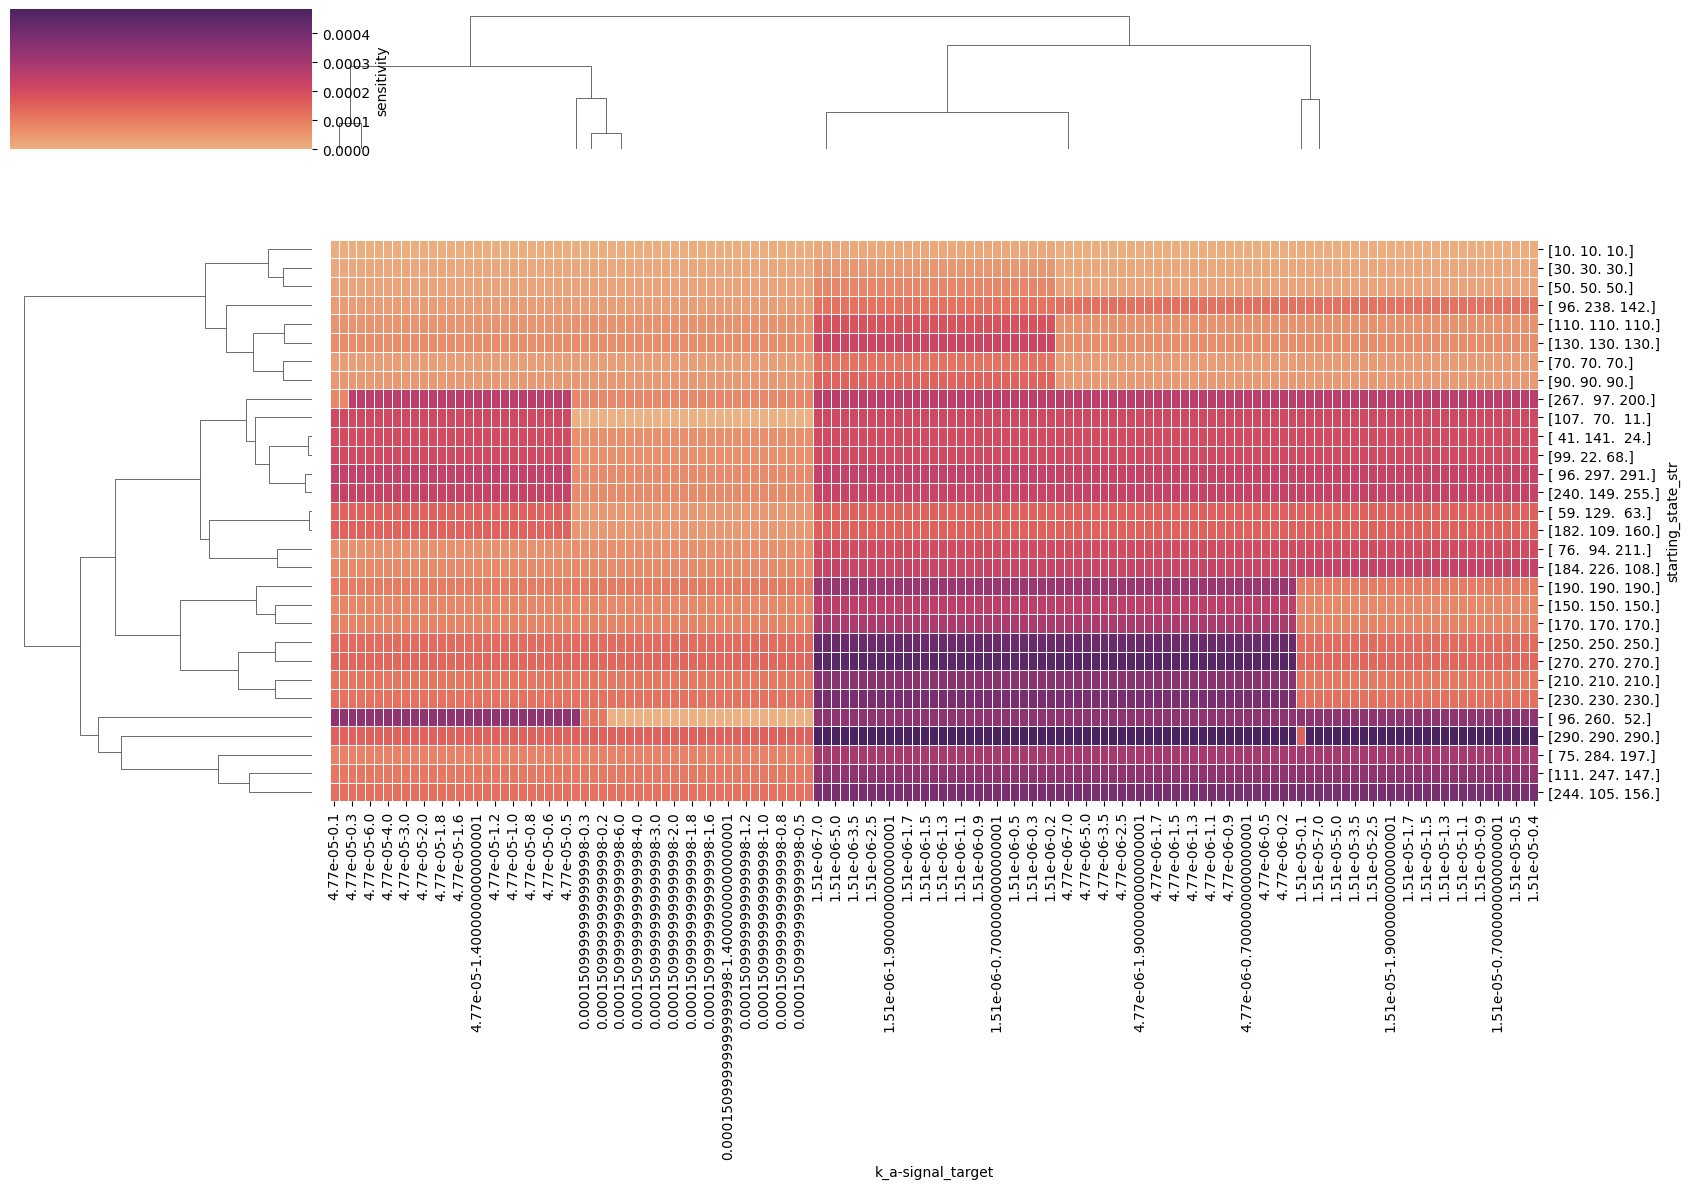

In [215]:
def plot_hierarchical_heatmap(df, cols_x, cols_y, value_col, cmap="viridis", aggfunc=np.mean, cluster=False):

    cols_x = [cols_x] if type(cols_x) is not list else cols_x
    cols_y = [cols_y] if type(cols_y) is not list else cols_y
    pivot_data = df.pivot_table(index=cols_x, columns=cols_y, values=value_col, aggfunc=aggfunc)
    pivot_data = pivot_data.sort_index(axis=0).sort_index(axis=1)
    pivot_data[pivot_data.isna()] = 0

    if cluster:
        sns.clustermap(pivot_data.T, 
                       cmap=cmap, 
                       cbar_kws={'label': value_col}, square=False, linewidths=0.5, figsize=(17, 12))
    else:
        fig, ax = plt.subplots(figsize=(17, 12))
        g = sns.heatmap(
            pivot_data.T, 
            cmap=cmap, 
            cbar_kws={'label': value_col}, 
            ax=ax, 
            square=False,
            linewidths=0.5
        ) 

        ax.set_xlabel(f"{' and '.join(cols_x)}", fontsize=12)
        ax.set_ylabel(f"{' and '.join(cols_y)}", fontsize=12)
        ax.set_title("Hierarchical Heatmap", fontsize=14)
        
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


data_circuits['sensitivity_log'] = np.log10(data_circuits['sensitivity'])
data_circuits['starting_state_str'] = data_circuits['starting_state'].apply(lambda x: str(x))
plot_hierarchical_heatmap(data_circuits, params_keys[:2], 'starting_state_str', 'sensitivity', 
                          cmap="flare", aggfunc=np.mean, cluster=True)
